# XRD-CT

This notebook demonstrates how to process powder X-ray diffraction computed tomography (XRD-CT) data acquired at beamline P07 at the DESY synchrotron. We start from integrated diffraction patterns, construct sinograms, determine the centre of rotation, perform self-absorption correction, and finally reconstruct the XRD-CT images.


## 1. Setup and Imports

We begin by importing the required libraries and utility functions from **nDTomo**. These include modules for reconstruction (`astra_rec_single`, `astra_rec_vol`), sinogram scaling and centering (`scalesinos`, `sinocentering`), circular masking (`cirmask`), and an interactive data viewer (`ImageSpectrumGUI`). Standard scientific Python libraries (`numpy`, `matplotlib`, `h5py`, `tifffile`) are also used for data handling and visualisation.


In [ ]:
from nDTomo.methods.hyperexpl import ImageSpectrumGUI
from nDTomo.tomo.astra_tomo import astra_rec_single, astra_rec_vol
from nDTomo.tomo.sinograms import scalesinos, sinocentering
from nDTomo.methods.misc import cirmask

import h5py, os, glob, time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

# %matplotlib qt

## 2. Scan Information

The dataset corresponds to a 0-180° XRD-CT scan of a lithium-ion battery sample (NMC532). Key parameters include:
- Number of projections  
- Number of translation steps  
We can determine them from the integrated diffraction data as each line scan (projection) corresponds to a single h5 file. So, this was a zigzag scan where the fast axis was the translation axis and the slow axis (steps) was the rotation axis.

In [4]:

dataset = 'nmc532_cycled_discharged_1_00001'

print('Processing %s' %dataset)

fn = 'E:\\Research\\Beamtime\\XRDCT\\DESY_2024_02\\eiger_filt1090\\%s\\sum_%s_data_000001.h5' %(dataset, dataset)
with h5py.File(fn, 'r') as f:
    print(f['data'].shape)
    nx = f['data'].shape[0]
print("Number of translation steps:",nx)

p = 'E:\\Research\\Beamtime\\XRDCT\\DESY_2024_02\\eiger_filt1090\\%s\\' %(dataset)
folder = Path(p)
nh5 = sum(1 for f in folder.glob("sum*.h5"))
print("Number of projections:", nh5)



Processing nmc532_cycled_discharged_1_00001
(1260, 1)
Number of translation steps: 1260
Number of projections: 401


## 3. Loading Integrated Diffraction Data

In this step we load the integrated diffraction patterns from the `.h5` files produced during the scan. Each file corresponds to one projection (rotation angle), and within it the detector data are stored as intensity versus scattering vector **q**.  

We construct a 3D array `s` with dimensions:
- **translation steps** (fast axis, horizontal motion across the sample)  
- **projections** (slow axis, rotation angle)  
- **q channels** (diffraction intensity bins)  

After loading all projections, we apply the following corrections:

- **Zigzag correction:** Because the scan was performed in a zigzag pattern, every second projection (even index) needs to be flipped along the translation axis to restore spatial consistency.  
- **Negative intensity cleanup:** Any negative values are set to zero, as they are non-physical and typically arise from detector noise or background subtraction artefacts.  
- **Trimming:** The final frame is removed to ensure that all projections have consistent dimensions.  
- **q-vector extraction:** We also load the scattering vector array (`q`) from the files, which will later serve as the diffraction axis in visualisations and reconstructions.  
- **Roll correction:** A one-pixel shift is applied to every second projection to properly align the zigzag-corrected data.  

The resulting dataset `s` is now ready for sinogram construction and further processing.

In [5]:

s = np.zeros((nx, nh5, 2047), dtype='float32')
for ii in tqdm(range(1, nh5+1)):
    fn = '%sxrd_%s_data_%.6d.h5' %(p, dataset, ii)
    with h5py.File(fn, 'r') as f:
        s[:,ii-1,:] = f['data'][:]
s[:,0::2,:] = s[::-1, 0::2,:]
s[s<0] = 0
s = s[:,:-1,:]

with h5py.File(fn, 'r') as f:
    q = np.array(f['q'][:])

s[:,0::2,:] = np.roll(s[:,0::2,:], shift = 1, axis = 0)


100%|██████████| 401/401 [01:19<00:00,  5.02it/s]


## 4. Quick Visualisation of Sinogram Data

To obtain a first overview of the dataset, we sum the diffraction intensity across the **q** axis for each pixel and display the resulting 2D image.  

This produces a grayscale map where each pixel corresponds to the total scattered intensity at a given translation and rotation position.  

**Why this is useful:**  
- It provides a quick check that the zigzag correction and alignment were applied correctly.  
- Strong contrast features (bright or dark bands) often correspond to regions of varying absorption or scattering power in the sample.  
- Any inconsistencies (such as stripes, missing frames, or artefacts) are easier to spot at this stage before moving on to sinogram generation and reconstruction.


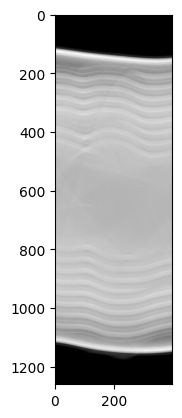

In [12]:
plt.figure(1);plt.clf()
plt.imshow(np.sum(s, axis=2), cmap='gray')
plt.show()

## 5. Loading Monitor and Absorption Data

Alongside the integrated diffraction patterns, the beamline also records monitor counts (`value1`) and transmitted absorption signal (`value2`) for each data acquisition point (i.e. each diffraction pattern recorded). These additional datasets are essential for **normalisation** and for later **self-absorption correction**.

- **Monitor signal (`s_moni`)**: tracks the incident beam intensity, which may fluctuate during the scan.  
- **Absorption signal (`s_abs`)**: measures the transmitted beam through the sample and provides a map of X-ray attenuation.  

Both datasets are stored in `.nxs` files (NeXus format), one per projection. We load them into arrays matching the translation/rotation grid of the diffraction data.  

After loading, we apply the same **zigzag correction** and **roll shift** used previously, so that these signals remain spatially aligned with the diffraction dataset.  

Finally, the absorption signal is **normalised** (`s_abs_n = s_abs / max(s_abs)`) to scale values between 0 and 1. This normalised absorption map will later serve as the basis for correcting diffraction intensities for self-absorption effects.

In [7]:


s_moni = np.zeros((s.shape[0], s.shape[1]+1), dtype = 'float32')
s_abs = np.zeros_like(s_moni)

p = 'U:\\_xrdct\\2024_02_DESY\\P07\\raw\\absdio\\batteries\\'

ss = np.zeros((nx, nh5))
for ii in tqdm(range(nh5)):
    
    fn = '%s%s_cnt_%.5d.nxs' %(p, dataset, ii)
    with h5py.File(fn, 'r') as f:
        s_moni[:,ii] = f['entry/data/value1'][:]
        s_abs[:,ii] = f['entry/data/value2'][:]

s_moni[:,0::2] = s_moni[::-1, 0::2]
s_abs[:,0::2] = s_abs[::-1, 0::2]

s_abs[:,0::2] = np.roll(s_abs[:,0::2], shift = 1, axis = 0)
s_abs_n = s_abs/np.max(s_abs)


100%|██████████| 401/401 [00:10<00:00, 37.02it/s]


## 6. Constructing Absorption Sinograms

To prepare for self-absorption correction, we construct sinograms from the absorption data:

1. **Normalisation by monitor signal:**  
   The raw absorption (`s_abs`) is divided by the monitor counts (`s_moni`) to compensate for beam intensity fluctuations across projections.  

2. **Scaling and log-transform:**  
   The result is normalised to its maximum and then converted to line integrals using `-log()`. This makes the absorption data suitable for tomographic reconstruction.  

3. **Sinogram scaling and alignment:**  
   The sinograms are scaled with `scalesinos`, corrected for zigzag geometry with a one-pixel roll, and trimmed to remove the last redundant frame.  

4. **Rebinning:**  
   To reduce noise and computational load, the sinograms are rebinned along the translation axis by averaging groups of three detector rows (`rf = 3`). This step preserves signal trends while smoothing small fluctuations.  

5. **Centre-of-rotation correction:**  
   The rebinned sinogram (`san`) is aligned using `sinocentering`, ensuring that projections at 0° and 180° match.  

Finally, the corrected absorption sinogram is displayed as a grayscale image for visual inspection.  

**Why this matters:**  
Accurate absorption sinograms are crucial for self-absorption correction of the diffraction data. Any misalignment or artefacts here would directly propagate into the reconstructed XRD-CT images.


100%|██████████| 420/420 [00:00<00:00, 70027.34it/s]


Calculating the COR


100%|██████████| 200/200 [00:00<00:00, 348.01it/s]


Calculated COR: 211.69999999999933
Applying the COR correction


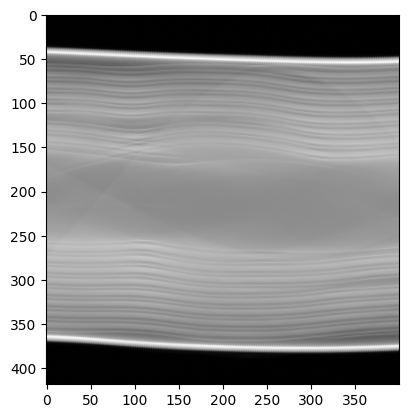

In [13]:

sa = s_abs/s_moni
sa = sa/np.max(sa)

sa = -np.log(sa)
sa = scalesinos(sa)

sa[:,0::2] = np.roll(sa[:,0::2], shift = 1, axis = 0)
sa = sa[:,:-1]

# rebin the sinograms
rf = 3
san = np.zeros((int(sa.shape[0]/rf), sa.shape[1]), dtype = 'float32')
for ii in tqdm(range(san.shape[0])):
    san[ii,:] = np.mean(sa[ii*rf:(ii + 1)*rf,:], axis = 0)

san = sinocentering(san, 10, scan=180)
san = scalesinos(san)

plt.figure(1);plt.clf()
plt.imshow(san, cmap = 'gray')
plt.show()


## 7. Absorption Reconstruction

We now reconstruct the absorption sinogram into a 2D tomographic slice using **filtered back-projection** (`astra_rec_single`).  

- The reconstructed absorption image (`ra`) represents the internal attenuation contrast of the battery sample.  
- A circular mask (`cirmask`) is applied to remove artefacts outside the valid field of view.  
- The result is plotted as a clean grayscale map, with axis ticks removed for clarity.  

This reconstructed absorption slice is also saved as a high-resolution PNG file.  

**Why this is important:**  
The absorption reconstruction provides a reference structural map of the sample. It will later be used to guide and validate the XRD-CT reconstructions, and serves as the basis for applying self-absorption corrections to the diffraction data.

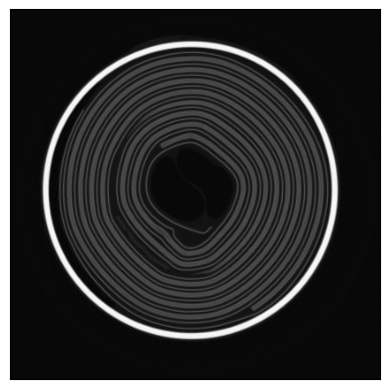

In [14]:

ra = astra_rec_single(san)
ra = cirmask(ra, 5)

plt.figure(1);plt.clf()
plt.imshow(ra, cmap = 'gray')
plt.xticks([])  
plt.yticks([])  
plt.savefig('%s_microct_2D.png' %dataset, dpi=300)
plt.show()

## 8. Self-Absorption Correction of Diffraction Data

The next step is to correct the diffraction sinograms for **self-absorption effects** using the absorption signal previously reconstructed:

1. **Normalisation by absorption:**  
   Each diffraction channel in `s` is divided by the normalised absorption map (`s_abs_n`). This compensates for the attenuation of diffracted X-rays within the sample, ensuring that the intensity variations reflect real structural features rather than geometry-dependent absorption.

2. **Centre-of-rotation correction:**  
   The corrected sinograms (`sn`) are aligned using `sinocentering` to refine the rotational axis.

3. **Rebinning:**  
   To reduce noise and computational load, the sinograms are rebinned by averaging pairs of detector rows along the translation axis. The rebinned dataset (`snr`) has half the spatial resolution in the fast axis but improved signal-to-noise ratio.

4. **Second centering and scaling:**  
   After rebinning, the sinograms are centred again and passed through `scalesinos` to ensure consistent scaling across all projections and diffraction channels.

The resulting dataset (`snr`) is now ready for tomographic reconstruction of individual diffraction channels.

In [15]:

sn = np.zeros_like(s)
for ii in tqdm(range(s.shape[2])):
    sn[:,:,ii] = s[:,:,ii]/s_abs_n[:,:-1]

sn = sinocentering(sn, 10, scan=180)

# rebin the sinograms
snr = np.zeros((int(sn.shape[0]/2), sn.shape[1], sn.shape[2]), dtype = 'float32')
for ii in tqdm(range(sn.shape[2])):
    for jj in range(snr.shape[0]):
        snr[jj,:,ii] = np.mean(sn[jj*2:jj*2+2,:,ii], axis = 0)

snr = sinocentering(snr, 10)

snr = scalesinos(snr)


100%|██████████| 2047/2047 [00:43<00:00, 47.52it/s]


Calculating the COR


100%|██████████| 200/200 [00:01<00:00, 142.89it/s]


Calculated COR: 633.5000000000031
Applying the COR correction


100%|██████████| 2047/2047 [00:43<00:00, 46.91it/s]


Calculating the COR


100%|██████████| 200/200 [00:00<00:00, 241.18it/s]


Calculated COR: 315.30000000000246
Applying the COR correction


100%|██████████| 2047/2047 [00:32<00:00, 63.93it/s]


## 9. Interactive Inspection of Corrected Sinograms

We launch the **ImageSpectrumGUI** to interactively explore the corrected and rebinned diffraction sinograms (`snr`).  

- The left-hand pane shows sinograms for a selected diffraction channel.  
- The right-hand pane displays the corresponding diffraction spectrum at a chosen pixel.  
- Navigation tools allow quick switching between translation, projection, and diffraction dimensions.  

**Purpose of this step:**  
Interactive inspection helps verify that the self-absorption correction and rebinning have been applied correctly. Artefacts such as misalignment, residual stripes, or intensity discontinuities can be spotted before proceeding to reconstruction.  

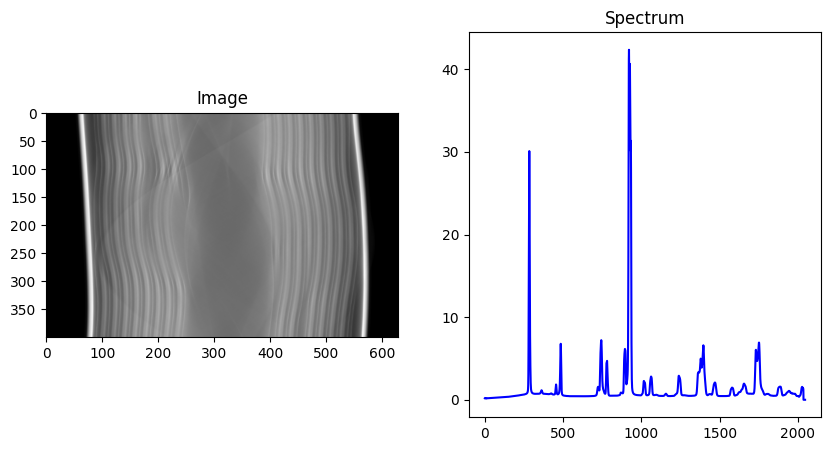

In [16]:
ImageSpectrumGUI(snr, cmap='gray')

## 10. XRD-CT Reconstruction

With the corrected diffraction sinograms (`snr`) prepared, we now perform full **XRD-CT reconstruction**:

- The projection angles are defined as a uniform grid between 0° and 180°, converted to radians.  
- The rebinned sinograms are reconstructed into a 3D volume using `astra_rec_vol`.  
- Negative values, which are non-physical, are clipped to zero.  

The resulting dataset (`rn`) is a 3D diffraction volume where each voxel contains a full diffraction spectrum. This is the core output of XRD-CT, enabling spatially resolved structural analysis of the sample.  

**Why this matters:**  
This step transforms raw diffraction data into a form that can be interrogated voxel-by-voxel, allowing phase identification, crystallite size analysis, and mapping of chemical heterogeneities across the battery sample.  

In [17]:

theta = np.deg2rad(np.linspace(0, 180, snr.shape[1]))
rn = astra_rec_vol(snr, theta=theta)
rn[rn<0] = 0


100%|██████████| 2047/2047 [01:15<00:00, 27.21it/s]


## 11. Interactive Exploration of the Reconstructed XRD-CT Volume

We again use **ImageSpectrumGUI** to explore the reconstructed 3D diffraction volume (`rn`):  

- Slice through the reconstructed volume to inspect spatial contrast across the sample.  
- Hover over any voxel to display its corresponding diffraction spectrum.  
- Navigate across spatial dimensions and diffraction channels to identify regions of interest.  

**Purpose:**  
This interactive view allows rapid quality assessment of the XRD-CT reconstruction. It helps to confirm that diffraction features are spatially localised, artefacts are minimised, and that the data are ready for downstream analysis such as phase mapping or peak fitting.  

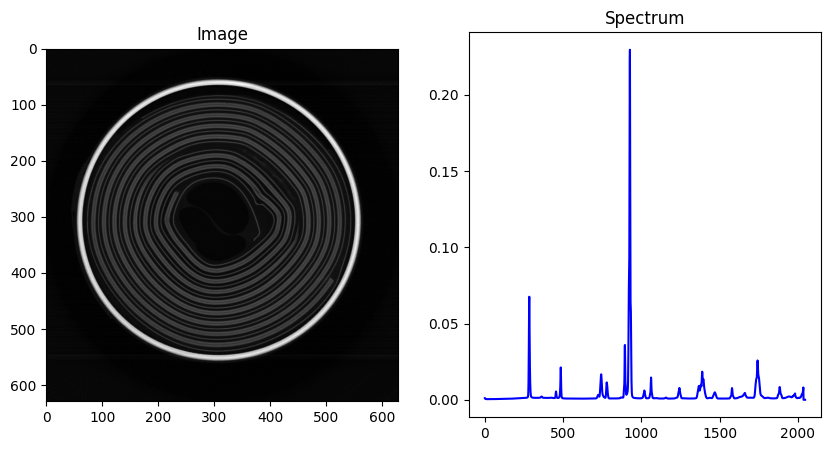

In [18]:
ImageSpectrumGUI(rn, cmap='gray')

## 12. Saving Processed Data

The final step is to save both the intermediate sinograms and the reconstructed diffraction volume into HDF5 (`.h5`) files for future use.  

Two files are created:  

1. **Raw sinograms and absorption data**  
   - `sinograms`: the uncorrected diffraction sinograms (`s`)  
   - `sinogram_absct`: the absorption sinograms (`s_abs`)  
   - `q`: the scattering vector axis  

2. **Corrected sinograms and reconstruction**  
   - `sinograms_abscor`: the self-absorption corrected and rebinned diffraction sinograms (`snr`)  
   - `data`: the reconstructed XRD-CT volume (`rn`)  
   - `q`: the scattering vector axis  

**Why this matters:**  
Saving both raw and processed datasets ensures full reproducibility. Users can revisit earlier stages (e.g., apply different corrections or reconstruction methods) without repeating the entire workflow from scratch.  


In [ ]:

fn = '%s_sinograms.h5' %dataset
with h5py.File(fn, 'w') as f:
    f.create_dataset('sinograms', data = s)
    f.create_dataset('sinogram_absct', data = s_abs)
    f.create_dataset('q', data = q)


fn = '%s_rec.h5' %dataset
with h5py.File(fn, 'w') as f:
    f.create_dataset('sinograms_abscor', data = snr)
    f.create_dataset('data', data = rn)
    f.create_dataset('q', data = q)


# Summary

In this notebook we have demonstrated the complete processing workflow for **XRD-CT data** acquired at beamline P07 (DESY). Starting from raw integrated diffraction patterns, we:  

1. Loaded the diffraction data and applied zigzag alignment corrections.  
2. Visualised summed projections to check data consistency.  
3. Loaded monitor and absorption signals to track beam fluctuations and transmission.  
4. Constructed and reconstructed absorption sinograms to map sample attenuation.  
5. Applied **self-absorption correction** to the diffraction data.  
6. Re-binned and centred the corrected sinograms for stability and noise reduction.  
7. Reconstructed a full **3D diffraction volume** using ASTRA.  
8. Interactively inspected the reconstructed volume to validate data quality.  
9. Saved both raw and corrected sinograms together with the reconstructed volume into `.h5` files for future analysis.  

This workflow transforms raw XRD-CT measurements into spatially resolved diffraction volumes, enabling voxel-by-voxel exploration of crystalline phases, lattice parameters, and structural heterogeneities in complex battery materials.  

The resulting datasets can now be used for advanced analysis steps such as **peak fitting, phase mapping, or multimodal correlation** with complementary imaging techniques available in the Battery Imaging Library.